***

# <font color=red>Bank Graph Example Notebook</font>
<p style="margin-left:10%; margin-right:10%;"><font color=teal>by Rahul Tasker</font></p>

***

Oracle Data Science service sample notebook.

Copyright (c) 2021, 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).



# Overview:

This notebook shows how we can access graphs in an autonomous database instance. We can then run algorithms on and query the graph. From the result set, we can transform the result set using common datascience tools like pandas, and pyplot.

Compatible conda pack: [Parallel Graph AnalytiX 23.1 and Oracle Property Graph 23.1 for CPU on Python 3.8](https://docs.oracle.com/en-us/iaas/data-science/using/conda-database-fam.htm) for CPU on Python 3.8 (version 1.0)

---

## Step 1: Import required libraries
This can also be done at any point in the notebook, but for simplicity, we can import all necessary libraries at the start to use them throughout the rest of the notebook.

In [1]:
from opg4py.adb import AdbClient
import pandas
import matplotlib.pyplot as plt
import oracledb
import opg4py
import csv

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/datascience/conda/pypgx2310_p38_cpu_v1/lib/python3.8/site-packages/pypgx/jars/log4j-slf4j-impl-2.17.1.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/datascience/conda/pypgx2310_p38_cpu_v1/lib/python3.8/site-packages/opg4py/jars/logback-classic-1.2.10.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]


## Step 2: Gather Connection Information and Connect to ADB
This notebook assumes that you have an Autonomous Database instance with a graph enabled user. If you have not, you can create an instance with a graph user automatically by clicking 'Deploy to Oracle Cloud' on this [reference architecture](https://docs.oracle.com/en/solutions/oci-adb-graph-analytics/index.html). 
<br/><br/>
The following paragraphs require that you gather some information from your OCI environment. This will allow the notebook to connect to your ADB instance. In the following paragraphs, replace any string enclosed by `<>` with the appropriate string. For example, replace `'<graph_user>'` with `'GRAPHUSER'`, assuming that is the name of your graph enabled user.
<br/><br/>
If your ADB instance has MTLS enabled, you will need to download the wallet and unzip it in a directory that is accessible from this notebook. If you have disabled MTLS, there are alternative connection options in the comments of these paragraphs. Be sure that your network rules allow you to connect to your ADB instance from this environment.
<br/><br/>
The paragraphs create the config for an Autonomous Database connection, creates a client connection, checks if the graph client is attached, starts the Graph Studio environment, and checks what user started the job creation job for Graph Studio. 

In [2]:
# Set environment variables

db_username = '<graph_user>'
db_password = '<graph_user_password>'
#connection_string = '<service_name>?TNS_ADMIN=/path/to/unzipped/wallet_dir'
connection_string = """(description=(retry_count=20)(retry_delay=3)(address=(protocol=tcps)(port=1521)(host=<host_url>))(connect_data=(service_name=<service_name>))(security=(ssl_server_dn_match=yes)))"""
jdbc_url = 'jdbc:oracle:thin:@' + connection_string

tenancy_ocid = '<tenancy_ocid>'
database_name = '<autonomous_database_name>'
database_ocid = '<autonomous_databse_ocid>'
endpoint = 'https://<hostname-prefix>.adb.<region>.oraclecloudapps.com/'


In [3]:
pgql_connection = opg4py.pgql.get_connection(db_username, db_password, jdbc_url)
pgql_statement = pgql_connection.create_statement()

oracledb.init_oracle_client()

# If you are using a wallet-based connection, use the below connection sytnax
# connection=oracledb.connect(
#      user=db_username,
#      password=db_password,
#      dsn=connection_string,
#      config_dir=<path to wallet directory>,
#      wallet_location=<path to wallet directory>,
#      wallet_password=<wallet password>)

# If you have MTLS disabled, you can use the following connection sytnax
connection = oracledb.connect(
    user=db_username,
    password=db_password,
    dsn=connection_string)

In [4]:
config = {
          'tenancy_ocid': tenancy_ocid,
          'database': database_name,
          'database_ocid': database_ocid,
          'username': db_username,
          'password': db_password,
          'endpoint': endpoint
 }

client = AdbClient(config)
client.__enter__()

In [5]:
if(not client.is_attached()):
    job = client.start_environment(10)
    job.get()
    job.get_name()
    print('Environment is now attached')
else:
    print('Environment is already attached')

Environment is already attached


## Step 3: Load Dataset and Create Property Graph

The following paragraphs will load the dataset into tables in your Autonomous Database instance, and run a Create Property Graph statement, to create the graph from the dataset.

In [6]:
# Collect the remote banking data
import pandas as pd

accounts_url  = "https://github.com/oracle-samples/pgx-samples/blob/pgql-samples/23c-graph-demos/BankGraphDataset/BANK_ACCOUNTS.csv?raw=true"
transfers_url = "https://github.com/oracle-samples/pgx-samples/blob/pgql-samples/23c-graph-demos/BankGraphDataset/BANK_TRANSFERS.csv?raw=true"

accounts = pd.read_csv(accounts_url, dtype=str).values.tolist()
transfers = pd.read_csv(transfers_url, dtype=str).values.tolist()

In [7]:
# Set up tables and property graphs. 

# IMPORTANT: This cell will remove any existing tables and graphs corresponding to the 
#            names listed. Doing so allows one to run this notebook multiple times.

# Function to verify if a table exists for the current user
def table_exists(tablename):
    with connection.cursor() as cursor:
        cursor.execute("""SELECT TABLE_NAME FROM USER_TABLES WHERE TABLE_NAME = :x1""", [tablename])
        return cursor.fetchone() is not None

# Function to execute a sql statement (create, insert, update, drop)  
def execute_statement(statement):
    with connection.cursor() as cursor:
        cursor.execute(statement)

if table_exists("BANK_TRANSFERS"):
    execute_statement("DROP TABLE BANK_TRANSFERS")
    
if table_exists("BANK_ACCOUNTS"):
    execute_statement("DROP TABLE BANK_ACCOUNTS")
    
# Drop an existing property graph
pgql_statement = pgql_connection.create_statement()
try:
    pgql_statement.execute("""DROP PROPERTY GRAPH bank_graph""")
except:
    pass


In [8]:
# Create BANK_ACCOUNTS table if it does not already exist
if not table_exists('BANK_ACCOUNTS'):
    s = '''CREATE TABLE BANK_ACCOUNTS (
                ID              NUMBER,
                NAME            VARCHAR(400),
                BALANCE         NUMBER(20,2)
            )'''
    execute_statement(s)
    
with connection.cursor() as cursor:
    cursor.executemany('''INSERT INTO BANK_ACCOUNTS VALUES(:x1, :x2, :x3)''', accounts)

    
# Create BANK_TRANSFERS table if it does not already exist
if not table_exists('BANK_TRANSFERS'):
    s = '''CREATE TABLE BANK_TRANSFERS (
                TXN_ID          NUMBER,
                SRC_ACCT_ID     NUMBER,
                DST_ACCT_ID     NUMBER,
                DESCRIPTION     VARCHAR(400),
                AMOUNT          NUMBER
            )'''
    execute_statement(s)

with connection.cursor() as cursor:
    cursor.executemany('''INSERT INTO BANK_TRANSFERS VALUES(:x1, :x2, :x3, :x4, :x5)''', transfers) 


# Add constraints
constraints = ['ALTER TABLE BANK_ACCOUNTS ADD PRIMARY KEY (ID)', 'ALTER TABLE BANK_TRANSFERS ADD PRIMARY KEY (TXN_ID)', 'ALTER TABLE BANK_TRANSFERS MODIFY SRC_ACCT_ID REFERENCES BANK_ACCOUNTS (ID)', 'ALTER TABLE BANK_TRANSFERS MODIFY DST_ACCT_ID REFERENCES BANK_ACCOUNTS (ID)']
for constraint in constraints: 
    execute_statement(constraint)

In [9]:
# Create a property graph view on bank_accounts and bank_transfers
    
statement = """CREATE PROPERTY GRAPH bank_graph 
    VERTEX TABLES (
        BANK_ACCOUNTS
        KEY (ID)
        PROPERTIES (ID, Name, Balance) 
    )
    EDGE TABLES (
        BANK_TRANSFERS 
        KEY (TXN_ID) 
        SOURCE KEY (src_acct_id) REFERENCES BANK_ACCOUNTS(ID)
        DESTINATION KEY (dst_acct_id) REFERENCES BANK_ACCOUNTS(ID)
        PROPERTIES (src_acct_id, dst_acct_id, amount)
    ) OPTIONS (PG_VIEW) """

pgql_statement.execute(statement)


False

## Step 4: Create PGX Session and Load Bank Graph into Memory

The next paragraph creates a pgx session. The paragraph after checks if the Bank Graph is already loaded into memory, if it is not, it is loaded.

In [10]:
instance = client.get_pgx_instance()
session = instance.create_session("adb-session")

In [11]:
GRAPH_NAME="BANK_GRAPH";
# try getting the graph from the in-memory graph server
graph = session.get_graph(GRAPH_NAME);
# if it does not exist read it into memory
if (graph == None) :
    session.read_graph_by_name(GRAPH_NAME, "pg_view")
    print("Graph "+ GRAPH_NAME + " successfully loaded")
    graph = session.get_graph(GRAPH_NAME);
else :
    print("Graph '"+ GRAPH_NAME + "' already loaded");

Graph BANK_GRAPH successfully loaded


## Step 5: Run PageRank Algorithm

Pagerank measures the importance of each node within the graph, based on the number incoming relationships and the importance of the corresponding source nodes

In [12]:
analyst = session.create_analyst()
analyst.pagerank(graph)

VertexProperty(name: pagerank, type: double, graph: BANK_GRAPH)

## Step 6: Query Graph

In [13]:
rs = graph.execute_pgql("SELECT a.id, a.pagerank FROM MATCH (a) ON bank_graph ORDER BY id asc")
rs.print()

+------------------------------+
| id   | pagerank              |
+------------------------------+
| 1    | 2.1326167755084552E-4 |
| 2    | 9.748675243734766E-4  |
| 3    | 1.7983500000000002E-4 |
| 4    | 0.004576976478097234  |
| 5    | 1.5000000000000001E-4 |
| 6    | 5.353395438612155E-4  |
| 7    | 4.792084983734147E-4  |
| 8    | 0.0013043345794813302 |
| 9    | 4.522665253472895E-4  |
| 10   | 0.001502117014779663  |
| 11   | 3.5429903308395303E-4 |
| 12   | 0.0010233112946381514 |
| 13   | 0.004442039241845869  |
| 14   | 1.5000000000000001E-4 |
| 15   | 3.646016316008686E-4  |
| 16   | 1.5000000000000001E-4 |
| 17   | 8.297194566709335E-4  |
| 18   | 4.6771412044819107E-4 |
| 19   | 0.0013126022053042005 |
| 20   | 3.748583285945889E-4  |
| 21   | 2.71786464817095E-4   |
| 22   | 4.978740859417255E-4  |
| 23   | 6.389910985428128E-4  |
| 24   | 8.099717847755725E-4  |
| 25   | 0.0010285248604570017 |
| 26   | 1.5000000000000001E-4 |
| 27   | 0.0018968861989483012 |
| 28   | 6

## Step 7: Convert to Pandas Dataframe 

In [14]:
result_df = rs.to_pandas()
print(result_df)

       id  pagerank
0       1  0.000213
1       2  0.000975
2       3  0.000180
3       4  0.004577
4       5  0.000150
..    ...       ...
995   996  0.000527
996   997  0.000150
997   998  0.002818
998   999  0.001016
999  1000  0.000150

[1000 rows x 2 columns]


In [15]:
# get basic statistics for the numerical columns of a Pandas DataFrame
result_df.describe()

,id,pagerank
count,1000.000000,1000.000000
mean,500.500000,0.001000
std,288.819436,0.001016
min,1.000000,0.000150
25%,250.750000,0.000234
50%,500.500000,0.000654
75%,750.250000,0.001395
max,1000.000000,0.007303


In [16]:
# Calculate the standard deviation of the given set of numbers, DataFrame, column, and rows
result_df.std()

id          288.819436
pagerank      0.001016
dtype: float64

## Step 8: Create Visualization Charts

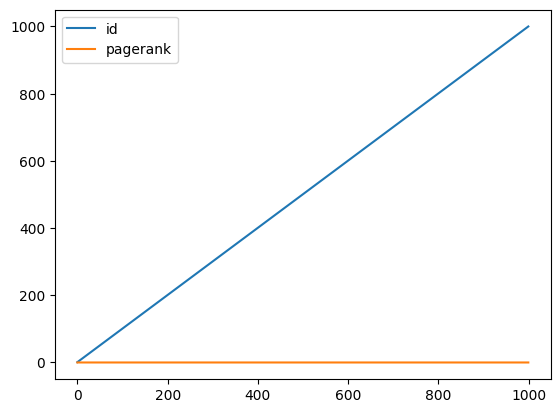

In [17]:
result_df.plot()
plt.show()

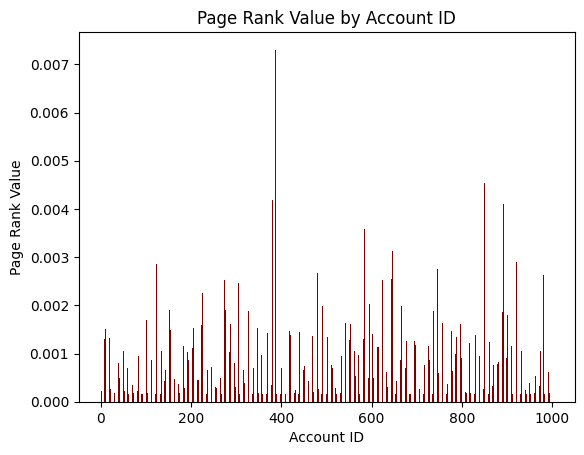

In [18]:
df = result_df.sort_values(by='id', ascending=False)
accounts = df['id']
values = df['pagerank']
plt.bar(accounts, values, color ='maroon', width = 0.4)
plt.xlabel("Account ID")
plt.ylabel("Page Rank Value")
plt.title("Page Rank Value by Account ID")
plt.show()

## Step 9: Close PGX Session

In [19]:
# Close the session after executing all graph queries
session.close()